This document makes wulff structure given mpid and surface energy dataset. 

The only thing you need to input is mpid_of_interest to run the script

In [17]:
mpid = 'mp-998985'
max_index = 2

#### Import packages

In [2]:
import csv
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymatgen_Wulff_hacked as Wulff

from gaspy import defaults, gasdb
from gaspy.tasks.atoms_generators import _EnumerateDistinctFacets   # local import to avoid import errors
from gaspy.tasks import core
from pymatgen.ext.matproj import MPRester
from sklearn.metrics import mean_absolute_error, mean_squared_error
from copy import deepcopy
from collections import defaultdict

api_key = 'MGOdX3P4nI18eKvE' 

####  get_surface_energy_docs

In [8]:
docs = gasdb.get_surface_docs()

# further sorting on surface energy (intercept) and interpolation uncertainty (intercept_uncertaity), as well as force on atoms
docs = [doc for doc in docs if doc['intercept'] <= 0.3 
#         and doc['intercept'] >= 0.02
        and doc['intercept_uncertainty'] <= 0.01]
print('# of surface energy calculation:', len(docs))

0it [00:00, ?it/s]

Now pulling surface documents...


3571it [00:04, 861.35it/s]

# of surface energy calculation: 3548


### Construct Wulff Structure

#####  Preprocess surfaces for each mpid
1. Select facets of the same mpid into a group. 
2. check if that mpid is missing any facets
2. Further divide each group of surfaces into smaller sets by miller indexes. 
3. For each set of surface (same mpid, same miller index), we record the surface with lowest surface energy for constructing wulff structure.  

In [14]:
class ModifyDocs:
    """
    This convert a surface dictionay in list to a class object. 
    """
    def __init__(self, doc):
        """
        Input:
            doc: an element in docs_results, represent a surface 
        """
        self.mongo_id = str(doc['mongo_id'])
        self.mpid = doc['mpid']
        self.miller = doc['miller']
        self.surface_energy = doc['intercept']
        self.uncertainty = doc['intercept_uncertainty']
        self.symbol_counts = doc['thinnest_structure']['atoms']['symbol_counts']
        self.spacegroup = doc['thinnest_structure']['atoms']['spacegroup']
        
class ModifyMpids:
    """
    This select surfaces with the same mpid into a group and 
    then further divided surfaces of the same miller indexes
    into smaller groups. Finally, the surface of each miller index with the 
    lowest surface energy is recorded. 
    """ 
    def __init__(self, mpid, docs):
        """
        Input:
            mpid: mpid entry
            docs: list of surface dictionaries
        """
        objs = [ModifyDocs(doc) for doc in docs]
        self.mpid = mpid
        self.match_objs = [obj for obj in objs if obj.mpid == mpid]
        
        # find subset with lowest miller energy
        match = sorted(self.match_objs, key = lambda x: getattr(x, 'miller'))
        match_subset = []
        m0 = match[0]
        for m in match:
            if m.miller == m0.miller:
                if m.surface_energy < m0.surface_energy:
                    m0 = deepcopy(m)
            else:
                match_subset.append(m0)
                m0 = deepcopy(m)
        match_subset.append(m0)
        self.match_subset = match_subset
        self.mpid_lowest = sorted(self.match_objs, key = lambda x: getattr(x, 'surface_energy'))[0]
        
    def take_ratio(self):
        """
        For each mpid, this take the ratio of all surface energy 
        to the lowest surface energy. 
        """
        ratio_target =  [[m.surface_energy/ self.mpid_lowest.surface_energy, m.train_tag] for m in self.match_subset]
        return ratio_target, ratio_predict
        
    def draw_wulff_shape(self):
        """
        Construct wulff shape.
        """
        millers =[m.miller for m in self.match_subset]
        surface_energy = [round(m.surface_energy,3) for m in self.match_subset]
        
        if len(millers) > 1:
            with MPRester(api_key) as m:
                structure = m.get_structure_by_material_id(self.mpid)
                ws_t =Wulff.WulffShape(structure.lattice, millers, surface_energy, symprec=1e-5)
        return  ws_t

##### Actual Wulff constructions

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


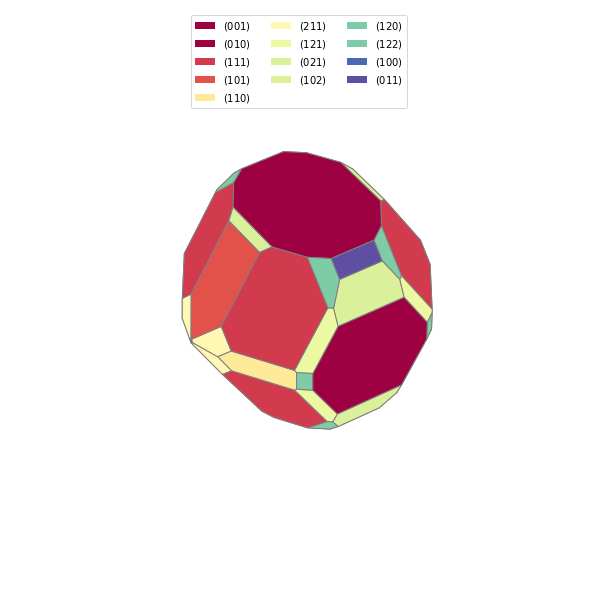

In [19]:
x = ModifyMpids(mpid, docs)
ws_t  = x.draw_wulff_shape()
ws_t.show() 

In [18]:
# obtain the details of each facets, i.e. their surface energy and area fraction 
example = x.match_subset[0]       
dicts = [ws_t.miller_energy_dict, ws_t.area_fraction_dict]
df_list = [pd.DataFrame.from_dict(d, orient='index') for d in dicts]
df = pd.concat(df_list, axis=1)
df.columns = ['Surface Energy',
              'Area Fraction']
df = df.round(3) # keep 3 sigfigs for dataframe
df

,Surface Energy,Area Fraction
"(0, 0, 1)",0.130,0.109
"(0, 1, 0)",0.114,0.000
"(0, 1, 1)",0.141,0.000
"(0, 1, 2)",0.129,0.115
"(0, 2, 1)",0.142,0.000
"(1, 0, 0)",0.118,0.000
"(1, 0, 1)",0.141,0.000
"(1, 0, 2)",0.139,0.052
"(1, 1, 0)",0.073,0.723
"(1, 1, 2)",0.160,0.000
